# Singular Value Decomposition

Singular Value Decomposition is explored on details here.

- Machine Learning Exploration : Singular Value Decomposition

    https://machinelearningexploration.readthedocs.io/en/latest/MathExploration/SingularValueDecomposition.html

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
ratings = pd.read_csv('/opt/datasetsRepo/RecommendationData/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
idx_to_userid_mapper = dict(enumerate(ratings.userId.unique()))
userid_to_idx_mapper = dict(zip(idx_to_userid_mapper.values(), idx_to_userid_mapper.keys()))

idx_to_movieid_mapper = dict(enumerate(ratings.movieId.unique()))
movieid_to_idx_mapper = dict(zip(idx_to_movieid_mapper.values(), idx_to_movieid_mapper.keys()))

ratings['user_idx'] = ratings['userId'].map(userid_to_idx_mapper).apply(np.int32)
ratings['movie_idx'] = ratings['movieId'].map(movieid_to_idx_mapper).apply(np.int32)
ratings.head(5)

,userId,movieId,rating,timestamp,user_idx,movie_idx
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4


In [5]:
user_movie_matrix = ratings.pivot_table(values=['rating'] ,index=['user_idx'], columns=['movie_idx'],
                                       fill_value=0)
user_movie_matrix.head(5)

rating                                               ...            \
movie_idx   0    1    2    3    4    5    6    7    8    9     ... 9714 9715   
user_idx                                                       ...             
0            4.0  4.0  4.0  5.0  5.0  3.0  5.0  4.0  5.0  5.0  ...    0  0.0   
1            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0  0.0   
2            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0  0.0   
3            0.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0  0.0   
4            4.0  0.0  0.0  0.0  4.0  0.0  0.0  4.0  0.0  0.0  ...    0  0.0   

                                                   
movie_idx 9716 9717 9718 9719 9720 9721 9722 9723  
user_idx                                           
0          0.0  0.0  0.0  0.0  0.0    0  0.0  0.0  
1          0.0  0.0  0.0  0.0  0.0    0  0.0  0.0  
2          0.0  0.0  0.0  0.0  0.0    0  0.0  0.0  
3          0.0  0.0  0.0  0.0  0.0    0  0.0  0.0  
4          0.0  0.0  0.0  0.0  0.0    0  0.0  0.0  

[5 rows x 9724 columns]

In [26]:
X = user_movie_matrix.values

In [46]:
X.shape

(610, 9724)

In [27]:
U, S, VT = np.linalg.svd(X, full_matrices=False)
U.shape, S.shape, VT.shape

((610, 610), (610,), (610, 9724))

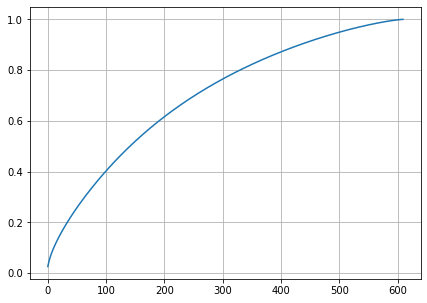

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.plot(S.cumsum()/S.sum(), "-")

ax.grid()
plt.show()

In [44]:
def loss(X, U, S, VT, rank):
    return np.sqrt(np.square(X - (U[:,:rank] @ np.diag(S[:rank]) @ VT[: rank, :])).sum())

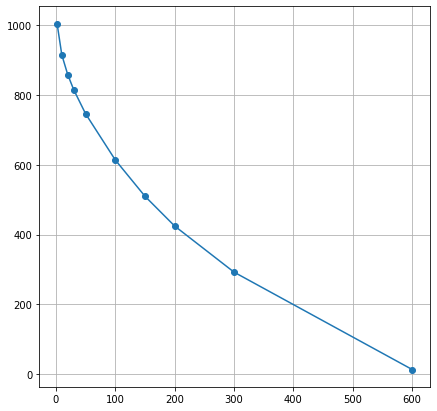

In [47]:
l_losses = []

ranks = [2, 10, 20, 30, 50, 100, 150, 200, 300, 600]
for i in ranks:
    l_losses.append(loss(X, U, S, VT, i))

fig, ax = plt.subplots(1, 1, figsize=(7,7))

ax.plot(ranks, l_losses, 'o-')

ax.grid()
plt.show()